
## Q2: DBSCAN algorithm:

### <span style='background:yellow'>(a)</span> How does it determine core points, border points, and noise points?

#### 1. Determine core points:
Core points in DBSCAN are specified by `2 hyperparmeter`:
- `Epsilon:` the radius of the circle to be created around each instance to check the density;
- `Min Neighbours:` the minimum number of neighbours required to be inside that circle

If an instance data point has at least min neighbours inside the given distance of Epsilon, we can say that instance is a core point.


#### 2. Determine border points:
A point can be determined as a border point if it is reachable from a core point but there are less than MinNeighbours number of points within its surrounding circle area


#### 3. Determine noise points:
A point cab be determined as noisy point (outlier) if it is not a core point and not reachable from any core points.

---

### <span style='background:yellow'>(b)</span> Write Python code to implement DBSCAN clustering using the same features as before and visualize the resulting clusters

#### 1. Loading data

In [4]:
# Load data:
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
import pandas as pd
iris = load_iris()

# select the 2 required features
iris_df = pd.DataFrame(data = iris['data'], columns = iris['feature_names']).iloc[:, -2:]
iris_df.head()

,petal length (cm),petal width (cm)
0,1.4,0.2
1,1.4,0.2
2,1.3,0.2
3,1.5,0.2
4,1.4,0.2


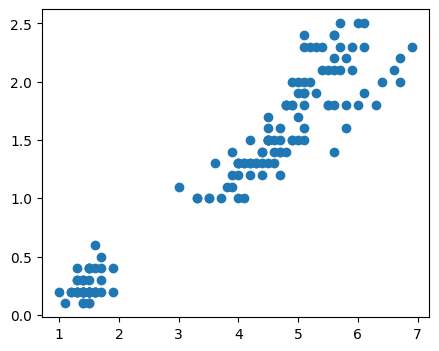

In [5]:
# Visualize the data:
import numpy as np
import matplotlib.pyplot as plt
X = iris_df.to_numpy()
plt.figure(figsize=(5, 4))
plt.scatter(X[:, 0], X[:, 1])
plt.show()

---
#### 2. Determine optimal `Epsilon`:
To determine the best epsilon value, we 
- First calculate the `average distance` between each point and its nearest neighbors;
- Then plot a k-distance: 
    - y-axis: we plot the average distances
    - x-axis: all the data points in dataset.
- Finally choose the epsilon value at the `elbow` of the graph. 

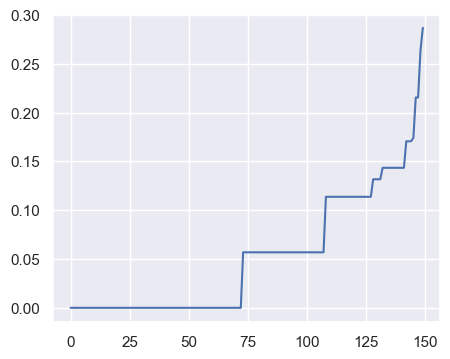

In [6]:
import numpy as np
from sklearn import metrics
from sklearn.cluster import DBSCAN
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X = scaler.fit_transform(iris_df)
X_recover = scaler.inverse_transform(X)

from sklearn.neighbors import NearestNeighbors
import seaborn as sns
sns.set()
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X)
distances, indices = nbrs.kneighbors(X)
distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.figure(figsize=(5, 4))
plt.plot(distances)

There are several elbow points here, we would say 0.15 looks better than the others, as this point has the maximum curvature. 
In the next section we also show the result of other epsilon values (0.05, 0.12, 0.15, 0.3) to prove why 0.15 is the best. 

---
#### 3. Determine optimal `minPts`:
- The larger the data set, the larger the value of MinPts should be
- If the data set is noisier, choose a larger value of MinPts
- Generally, MinPts should be >= the dimensionality of the data set
- For 2-dimensional data, use DBSCAN’s default value of MinPts = 4
- If your data has more than `2 dimensions`, choose `MinPts = 2*dim`, where dim= the dimensions of your data set

In our case, we only have 2 dimensions (petal length & width), so we set `MinPts = 4`

---
#### 4. Compute the DBSCAN

In [7]:
import numpy as np
from sklearn import metrics
from sklearn.cluster import DBSCAN
import matplotlib.gridspec as gridspec
from sklearn.preprocessing import StandardScaler

# scale the petal width & length for clustering
scaler = StandardScaler()
X = scaler.fit_transform(iris_df)

# retain the original unscaled data for final visualization
X_recover = scaler.inverse_transform(X)

# start the DBSCAN computing
db_005 = DBSCAN(eps=.05, min_samples=4).fit(X)
db_012 = DBSCAN(eps=.12, min_samples=4).fit(X)
db_015 = DBSCAN(eps=.15, min_samples=4).fit(X)
db_030 = DBSCAN(eps=.30, min_samples=4).fit(X)

labels_005 = db_005.labels_
labels_012 = db_012.labels_
labels_015 = db_015.labels_
labels_030 = db_030.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_005 = len(set(labels_005)) - (1 if -1 in labels_005 else 0)
n_clusters_012 = len(set(labels_012)) - (1 if -1 in labels_012 else 0)
n_clusters_015 = len(set(labels_015)) - (1 if -1 in labels_015 else 0)
n_clusters_030 = len(set(labels_030)) - (1 if -1 in labels_030 else 0)

n_noise_005 = list(labels_005).count(-1)
n_noise_012 = list(labels_012).count(-1)
n_noise_015 = list(labels_015).count(-1)
n_noise_030 = list(labels_030).count(-1)

table = [[n_clusters_005, n_noise_005],
         [n_clusters_012, n_noise_012],
         [n_clusters_015, n_noise_015],
         [n_clusters_030, n_noise_030]
        ]
df = pd.DataFrame(table, 
                  columns = ['Estimated number of clusters', 'Estimated number of noise points'], 
                  index=['eps = .05', 'eps = .12', 'eps = .15', 'eps = .30'])
print(df)

           Estimated number of clusters  Estimated number of noise points
eps = .05                             5                               121
eps = .12                            14                                42
eps = .15                             5                                16
eps = .30                             2                                 0


This summary already gives us some ideas about the optimal epsilon:
- If epsilon is chosen much too small, a large part of the data will not be clustered
    - e.g.: eps =.05, with very highnoise points 121
- Whereas a high epsilon value clusters will merge and the majority of data points will be in the same cluster
    - e.g.: eps = .30, only 2 clusters and all noise points are inluded

In general, small values of epsilon are preferable, and as a rule of thumb, only a small fraction of points should be within this distance of each other.

---
#### 5. Visualize our result

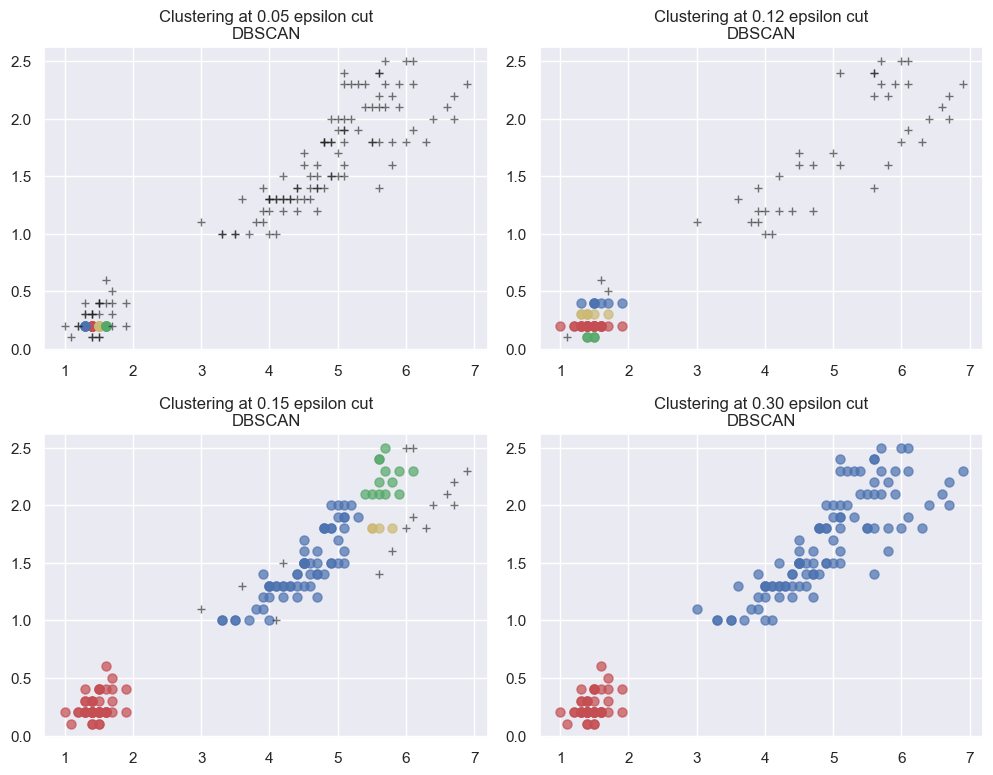

In [8]:
# (NOTE: visualize by original data X_recover, rather than the scaled one)
plt.figure(figsize=(20, 15))
G = gridspec.GridSpec(4, 4)
ax1 = plt.subplot(G[1, 0])
ax2 = plt.subplot(G[1, 1])
ax3 = plt.subplot(G[2, 0])
ax4 = plt.subplot(G[2, 1])

# DBSCAN at eps = 0.05
colors = ["r.", "b.", "y.", "g."]
for klass, color in zip(range(0, 4), colors):
    Xk = X_recover[labels_005 == klass]
    ax1.plot(Xk[:, 0], Xk[:, 1], color, alpha=.7, markersize = 13)
ax1.plot(X_recover[labels_005 == -1, 0], X_recover[labels_005 == -1, 1], "k+", alpha=0.6)
ax1.set_title("Clustering at 0.05 epsilon cut\nDBSCAN")

# DBSCAN at eps = 0.12
colors = ["r.", "b.", "y.", "g."]
for klass, color in zip(range(0, 4), colors):
    Xk = X_recover[labels_012 == klass]
    ax2.plot(Xk[:, 0], Xk[:, 1], color, alpha=.7, markersize = 13)
ax2.plot(X_recover[labels_012 == -1, 0], X_recover[labels_012 == -1, 1], "k+", alpha=0.6)
ax2.set_title("Clustering at 0.12 epsilon cut\nDBSCAN")

# DBSCAN at eps = 0.15
colors = ["r.", "b.", "y.", "g."]
for klass, color in zip(range(0, 4), colors):
    Xk = X_recover[labels_015 == klass]
    ax3.plot(Xk[:, 0], Xk[:, 1], color, alpha=.7, markersize = 13)
ax3.plot(X_recover[labels_015 == -1, 0], X_recover[labels_015 == -1, 1], "k+", alpha=0.6)
ax3.set_title("Clustering at 0.15 epsilon cut\nDBSCAN")

# DBSCAN at eps = 0.30
colors = ["r.", "b.", "y.", "g."]
for klass, color in zip(range(0, 4), colors):
    Xk = X_recover[labels_030 == klass]
    ax4.plot(Xk[:, 0], Xk[:, 1], color, alpha=.7, markersize = 13)
ax4.plot(X_recover[labels_030 == -1, 0], X_recover[labels_030 == -1, 1], "k+", alpha=0.6)
ax4.set_title("Clustering at 0.30 epsilon cut\nDBSCAN")

plt.tight_layout()
plt.show()

In conclusion, maybe `0.15 is the optimal epsilon` for our case, which is not underfitting with too many outliers and also not overfitting with inludint all noises.